In [1]:
import VariationalBayes as vb
import LogisticGLMM_lib as logit_glmm
from VariationalBayes.SparseObjectives import \
    Objective, pack_csr_matrix

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import autograd

import copy
from scipy import optimize

import os
import json

import time

import pickle


In [2]:
# Load data saved by stan_results_to_json.R and run_stan.R in LRVBLogitGLMM.

simulate_data = False

if not simulate_data:
    #analysis_name = 'simulated_data_small'
    analysis_name = 'criteo_subsampled'

    data_dir = os.path.join(os.environ['GIT_REPO_LOC'],
                            'LinearResponseVariationalBayes.py/Models/LogisticGLMM/data')
    json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)
    y_g_vec, y_vec, x_mat, glmm_par, prior_par = logit_glmm.load_json_data(json_filename)
    
    K = x_mat.shape[1]
    NG = np.max(y_g_vec) + 1

else:
    # Generate data
    N = 200     # observations per group
    K = 5      # dimension of regressors
    NG = 200      # number of groups

    true_beta = np.array(range(5))
    true_beta = true_beta - np.mean(true_beta)
    true_mu = 0.
    true_tau = 40.0

    x_mat, y_g_vec, y_vec, true_rho, true_u = \
        logit_glmm.simulate_data(N, NG, true_beta, true_mu, true_tau)
    prior_par = logit_glmm.get_default_prior_params(K)
    glmm_par = logit_glmm.get_glmm_parameters(K=K, NG=NG)


print(np.mean(y_vec))

dict_keys(['tau_prior_alpha', 'tau_prior_beta', 'y_group', 'beta_prior_info', 'N', 'y', 'NG', 'mu_prior_info', 'beta_prior_mean', 'mu_prior_mean', 'K', 'x'])
0.213409806931


In [3]:
# Initialize.

if False:
    # Slightly smarter inits would probably improve fit time, but as of now it doesn't
    # seem worth explaining in the paper.
    import pandas as pd
    #print(glmm_par)

    x_t_x = np.matmul(x_mat.transpose(), x_mat)
    x_t_y = np.matmul(x_mat.transpose(), y_vec)
    beta_init = np.linalg.solve(x_t_x, x_t_y)
    #print(beta_init)
    #plt.plot(sp.special.expit(np.matmul(x_mat, beta_init)), y_vec, 'k.')

    df = pd.DataFrame({ 'y_g': y_g_vec, 'y': y_vec}).groupby('y_g')
    #print(df.sum())
    u_init = np.array(df.sum()) / np.array(df.count()['y'])
    #plt.figure()
    print(np.min(y_g_vec))
    #plt.plot(u_init[y_g_vec], y_vec, 'k.')

logit_glmm.initialize_glmm_pars(glmm_par)
free_par_vec = glmm_par.get_free()
init_par_vec = copy.deepcopy(free_par_vec)


In [4]:
model = logit_glmm.LogisticGLMM(glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_gh_points=4)
model.get_e_log_prior()
model.get_log_lik()
model.get_entropy()

model.objective.fun_free(free_par_vec)

import timeit

time_num = 10

num_draws = 3
model.set_gh_points(num_draws)
print('num_draws = ', num_draws)
print('\tFunction time:',
      timeit.timeit(lambda: model.objective.fun_free(free_par_vec), number=time_num) / time_num)

print('\tGrad time:', 
      timeit.timeit(lambda: model.objective.fun_free_grad(free_par_vec), number=time_num) / time_num)

print('\tHessian vector product time:',
      timeit.timeit(lambda: model.objective.fun_free_hvp(
          free_par_vec, free_par_vec + 1), number=time_num) / time_num)

prior_vec = model.prior_par.get_vector()
prior_hess_time = time.time()
model.get_prior_hess(prior_vec, init_par_vec)
prior_hess_time = time.time() - prior_hess_time
print('\tPrior hess time: ', prior_hess_time)

num_draws =  3
	Function time: 0.011097209999570623
	Grad time: 0.05566882590064779
	Hessian vector product time: 0.10863677089801058
	Prior hess time:  0.07895565032958984


In [5]:
NG

5000

In [6]:
# Optimize.

print('Running Newton Trust Region.')
num_gh_points = 4
vb_time = time.time()
vb_opt = model.tr_optimize(init_par_vec, num_gh_points, gtol=1e-6, maxiter=500)
opt_x = vb_opt.x
vb_time = time.time() - vb_time

print('VB time: ', vb_time)
print('Done.')

Running Newton Trust Region.
Iter  0  value:  162354.434209
Iter  5  value:  38998.7177003
Iter  10  value:  30431.1788754
Iter  15  value:  26782.1514434
Iter  20  value:  24120.4150104
Iter  25  value:  23887.7607659
Iter  30  value:  23879.5113972
Iter  35  value:  23846.481109
Iter  40  value:  23825.9452651
Iter  45  value:  23825.6016527
Optimization terminated successfully.
         Current function value: 23825.601642
         Iterations: 48
         Function evaluations: 49
         Gradient evaluations: 49
         Hessian evaluations: 0
VB time:  63.994152307510376
Done.


VB time:  63.994152307510376


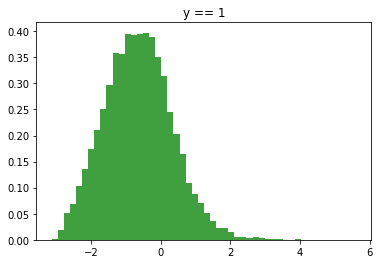

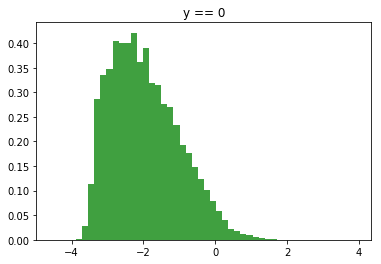

In [7]:
print('VB time: ', vb_time)

import scipy as sp

glmm_par_opt = copy.deepcopy(glmm_par)
glmm_par_opt.set_free(opt_x)

e_beta = glmm_par_opt['beta'].e()
e_u = glmm_par_opt['u'].e()[model.y_g_vec]

z_mean = e_u + np.matmul(model.x_mat, e_beta)

plt.figure()
plt.hist(z_mean[model.y_vec == 1], 50, normed=1, facecolor='green', alpha=0.75)
plt.title('y == 1')

plt.figure()
plt.hist(z_mean[model.y_vec == 0], 50, normed=1, facecolor='green', alpha=0.75)
plt.title('y == 0')




In [8]:
# # In case you want to save without calculating the Hessian, instantiate them here
if False:
    hess_time = 0.
    log_prior_hess = np.array([0.])
    kl_hess = np.array([0.])
    moment_jac = np.array([0.])
    lrvb_cov = np.array([0.])

In [14]:
# Get the Hessians at the number of draws used for optimization
model.glmm_par.set_free(opt_x)

hess_time = time.time()
print('KL Hessian...\n')
kl_hess = model.get_sparse_free_hessian(opt_x, print_every_n=100)

print('Log prior Hessian...\n')
log_prior_hess = model.get_prior_hess(prior_par.get_vector(), opt_x)

moment_jac = model.moment_wrapper.get_moment_jacobian(opt_x)

hess_time =  time.time() - hess_time

print('hess_time: %f' % hess_time)

KL Hessian...

Group 0 of 4999.
Group 100 of 4999.
Group 200 of 4999.
Group 300 of 4999.
Group 400 of 4999.
Group 500 of 4999.
Group 600 of 4999.
Group 700 of 4999.
Group 800 of 4999.
Group 900 of 4999.
Group 1000 of 4999.
Group 1100 of 4999.
Group 1200 of 4999.
Group 1300 of 4999.
Group 1400 of 4999.
Group 1500 of 4999.
Group 1600 of 4999.
Group 1700 of 4999.
Group 1800 of 4999.
Group 1900 of 4999.
Group 2000 of 4999.
Group 2100 of 4999.
Group 2200 of 4999.
Group 2300 of 4999.
Group 2400 of 4999.
Group 2500 of 4999.
Group 2600 of 4999.
Group 2700 of 4999.
Group 2800 of 4999.
Group 2900 of 4999.
Group 3000 of 4999.
Group 3100 of 4999.
Group 3200 of 4999.
Group 3300 of 4999.
Group 3400 of 4999.
Group 3500 of 4999.
Group 3600 of 4999.
Group 3700 of 4999.
Group 3800 of 4999.
Group 3900 of 4999.
Group 4000 of 4999.
Group 4100 of 4999.
Group 4200 of 4999.
Group 4300 of 4999.
Group 4400 of 4999.
Group 4500 of 4999.
Group 4600 of 4999.
Group 4700 of 4999.
Group 4800 of 4999.
Group 4900 of 499

/home/rgiordan/Documents/git_repos/autograd/autograd/core.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Log prior Hessian...

hess_time: 75.870354


In [10]:
print('Solving systems...\n')
inverse_time = time.time()
from scikits.sparse.cholmod import cholesky
kl_hess_chol = cholesky(kl_hess)
kl_inv_moment_jac = kl_hess_chol.solve_A(moment_jac.T)
lrvb_cov = np.matmul(moment_jac, kl_inv_moment_jac)
vb_prior_sens = np.matmul(log_prior_hess, kl_inv_moment_jac).T

inverse_time = time.time() - inverse_time
print('Done\n')

print('Inverse time:', inverse_time)

Solving systems...



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  after removing the cwd from sys.path.


Done

Inverse time: 5.103811979293823


In [11]:
if False:
    old_inv_time = time.time()
    kl_inv_moment_jac_solve = sp.sparse.linalg.spsolve(kl_hess, moment_jac.T)
    old_inv_time = time.time() - old_inv_time

    print('Difference:', np.linalg.norm(kl_inv_moment_jac_solve - kl_inv_moment_jac))
    print('Old time: ', old_inv_time)

In [12]:
# Time using conjugate gradient to get a single row of the moment sensitivity.
import scipy as sp
from scipy.sparse.linalg import LinearOperator

class OptimumHVP(object):
    def __init__(self, glmm_par, opt_x, moment_jac):
        self.verbose = False
        self.print_every = 10
        self.reset_iter()
        self.opt_x = opt_x
        self.moment_jac = moment_jac
        self.lo = LinearOperator(
            (glmm_par.free_size(), glmm_par.free_size()), self.hvp)
        
    def reset_iter(self):
        self.iter = 0
    
    def hvp(self, vec):
        self.iter += 1
        if self.verbose and self.iter % self.print_every == 0:
            print('Iter ', self.iter)
        return model.objective.fun_free_hvp(self.opt_x, vec)
    
    def get_moment_sensitivity_row(self, moment_row):
        self.reset_iter()
        moment_jac_vec = moment_jac[moment_row, :].flatten()
        cg_res, info = sp.sparse.linalg.cg(self.lo, moment_jac_vec)
        return cg_res, info

moment_row = 0
optimum_hvp = OptimumHVP(glmm_par, opt_x, moment_jac)
optimum_hvp.verbose = True
optimum_hvp.print_every = 20
cg_row_time = time.time()
cg_res, info = optimum_hvp.get_moment_sensitivity_row(0)
cg_row_time = time.time() - cg_row_time

print('CG time: ', cg_row_time)
num_cg_iterations = optimum_hvp.iter
print('Number of iterations: ', optimum_hvp.iter)

print(np.max(np.abs(cg_res - kl_inv_moment_jac[:, moment_row].flatten())))

Iter  20
Iter  40
Iter  60
Iter  80
CG time:  10.199395179748535
Number of iterations:  81
8.58809948572e-07


In [13]:
if not simulate_data:
    # Write the result to a JSON file for use in R.
    
    run_name = 'production'
    
    pickle_output_filename = os.path.join(data_dir, '%s_python_vb_results.pkl' % analysis_name)
    pickle_output = open(pickle_output_filename, 'wb')

    # Unlike with JSON, numpy arrays can be pickled.
    # Note that it does not seem that you can pickle a sparse Cholesky decomposition.
    pickle_result_dict = {  'glmm_par_dictval': glmm_par_opt.dictval(),
                            'glmm_par_vector': glmm_par_opt.get_vector(),
                            'glmm_par_free': glmm_par_opt.get_free(),
                            'run_name': run_name,
                            'vb_time': vb_time,
                            'hess_time': hess_time,
                            'inverse_time': inverse_time,
                            'cg_row_time': cg_row_time,
                            'num_cg_iterations': num_cg_iterations,
                            'num_gh_points': num_gh_points, 
                            'lrvb_cov': np.squeeze(lrvb_cov),
                            'moment_jac': np.squeeze(moment_jac),
                            'kl_inv_moment_jac': kl_inv_moment_jac,
                            'kl_hess_packed': pack_csr_matrix(kl_hess),
                            'vb_prior_sens': np.squeeze(vb_prior_sens),
                            'log_prior_hess': np.squeeze(log_prior_hess) }

    # Pickle dictionary using protocol 0.
    pickle.dump(pickle_result_dict, pickle_output)
    pickle_output.close()
    
    print(pickle_output_filename)


print('\n\nDONE.')
    

/home/rgiordan/Documents/git_repos/LinearResponseVariationalBayes.py/Models/LogisticGLMM/data/criteo_subsampled_python_vb_results.pkl


DONE.
